<a href="https://colab.research.google.com/github/LOOKatKimhyein/CRM-analysis/blob/main/(3)%EC%98%A8%EB%9D%BC%EC%9D%B8%EB%AA%B0_%EB%8F%99%EC%8B%9C%EA%B5%AC%EB%A7%A4%EC%83%81%ED%92%88%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 공부할 때, 참고하면 좋은!
https://github.com/mnegypt/jupyter-notebooks/blob/master/IMarketBasket.ipynb

# 1) 환경설정

In [ ]:
# 연관성분석(추천)  패키지 다운로드 및 설치 
# !pip install mlxtend --upgrade

In [ ]:
## 1. 분석에 사용할 패키지 로딩
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

import datetime as dt # 날짜를 다루기 위한 패키지

from mlxtend.preprocessing import TransactionEncoder # 구매 데이터를 연관성 분석을 위한 메트릭스 형태로 변환
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth 
# fpgrowth 는 mlxtend version: 0.20.0 이상에서 지원
# apriori : 보편적이고 간단
# fpgrowth : 연관성 분석알고리즘 중 최신 알고리즘

In [ ]:
data = pd.read_csv('./data.csv', encoding = 'unicode_escape')
# unicode_escape : 유니코드 디코드 에러 자체를 무시하는 방법

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data['InvoiceDate']

0          12/1/2010 8:26
1          12/1/2010 8:26
2          12/1/2010 8:26
3          12/1/2010 8:26
4          12/1/2010 8:26
               ...       
541904    12/9/2011 12:50
541905    12/9/2011 12:50
541906    12/9/2011 12:50
541907    12/9/2011 12:50
541908    12/9/2011 12:50
Name: InvoiceDate, Length: 541909, dtype: object

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
data[data.CustomerID.isna()].head(3)
# 연관성 분석에서는 고객id기준이 아닌, 영수증기준이므로, 고객id null값도 버리지 않을것!

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom


In [ ]:
data[data.Description.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom


In [ ]:
data[data.Description.isna()]['UnitPrice'].value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

##### description이 결측인데 stockcode랑 mapping안되는게 있는지 확인!  
description이 null이어도 안버리고 가져가보려고!  
> 했으나,,다 unitprice 0원,,

In [ ]:
des_na_sc = data[data.Description.isna()]['StockCode'].unique().tolist()

In [ ]:
dic = pd.DataFrame(data.groupby('StockCode')['Description'].count()).reset_index()

In [ ]:
dic[(dic.StockCode.isin(des_na_sc))&dic['Description'].isna()]

,StockCode,Description


## 데이터 탐색 및 이상치 제거

In [ ]:
data.shape

(541909, 8)

In [ ]:
# 1) UnitPrice = 0 제거
data1 = data[data.UnitPrice >0]

In [ ]:
data1.shape

(539392, 8)

In [ ]:
data1.describe()

,Quantity,UnitPrice,CustomerID
count,539392.000000,539392.000000,406789.000000
mean,9.845904,4.673648,15287.795830
std,215.412652,94.614722,1713.573064
min,-80995.000000,0.001000,12346.000000
25%,1.000000,1.250000,13954.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# 2) Quantity < 0 이면 환불건! 확인 후 제거
set([x[:1] for x in data1[data1.Quantity < 0]['InvoiceNo']])

{'C'}

In [ ]:
data1 = data1[data1.Quantity >=0]

In [ ]:
data1.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [ ]:
# 고객별 Quantity 이상치 확인
data1[data1.Quantity == 80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [ ]:
np.percentile(data1.Quantity,75) + 1.5*(np.percentile(data1.Quantity,75)-np.percentile(data1.Quantity,25))

23.5

In [ ]:
np.percentile(data1.Quantity,99)

100.0

(0.0, 100.0)

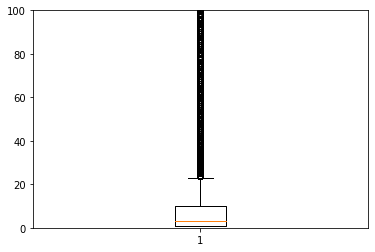

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(data1['Quantity'])
ax.set_ylim (0,100)

In [ ]:
print(data1.Quantity.mean() + data1.Quantity.std(),data1.Quantity.mean() + data1.Quantity.std()*3)

166.06616054487858 477.1144075661511


In [ ]:
data2 = data1[data1.Quantity <= 100].reset_index(drop=True)

In [ ]:
data2.describe()

,Quantity,UnitPrice,CustomerID
count,525255.000000,525255.000000,393225.000000
mean,7.936888,3.930387,15294.104904
std,12.558855,36.080000,1712.009054
min,1.000000,0.001000,12347.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.100000,15159.000000
75%,10.000000,4.130000,16794.000000
max,100.000000,13541.330000,18287.000000


#### Invoiceno 기준으로 테이블 변경 후, 이상치 검증  
: data2 너무 건 적어져서 우선 data1으로

In [ ]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
data_invoice_cnt = pd.DataFrame(data1.groupby('InvoiceNo')['StockCode'].count()).reset_index()

In [ ]:
data_invoice_cnt.rename({'StockCode':'n'},axis = 1, inplace = True)

In [ ]:
data_invoice_cnt

,InvoiceNo,n
0,536365,7
1,536366,2
2,536367,12
3,536368,4
4,536369,1
...,...,...
19955,581584,2
19956,581585,21
19957,581586,4
19958,581587,15


In [ ]:
data_invoice_cnt.describe()

,n
count,19542.000000
mean,26.878262
std,47.888395
min,1.000000
25%,7.000000
50%,16.000000
75%,29.000000
max,1110.000000


(0.0, 100.0)

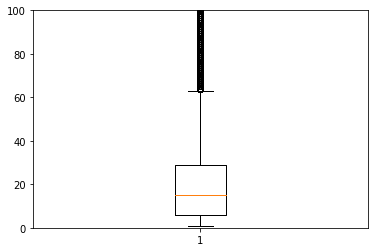

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(data_invoice_cnt['n'])
ax.set_ylim (0,100)

In [ ]:
data_invoice_cnt['n'].quantile(.99)

219.40999999999985

In [ ]:
data_invoice_cnt['n'].quantile(.75) + 1.5*(data_invoice_cnt['n'].quantile(.75)-data_invoice_cnt['n'].quantile(.25))

63.5

In [ ]:
print(data_invoice_cnt['n'].mean() + data_invoice_cnt['n'].std(), data_invoice_cnt['n'].mean() + data_invoice_cnt['n'].std()*3)

74.10038236879666 169.18451383985692


In [ ]:
data_invoice_cnt.shape

(19960, 2)

In [ ]:
outlier_treat = data_invoice_cnt[(data_invoice_cnt.n >= 2)  & (data_invoice_cnt.n <= 150)]

In [ ]:
data2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
pur_outlier_treat = pd.merge(outlier_treat,data2, how= 'inner', on='InvoiceNo')

In [ ]:
pur_outlier_treat.describe()

,n,Quantity,UnitPrice,CustomerID
count,409659.000000,409659.000000,409659.000000,377744.000000
mean,44.740753,9.300894,3.285169,15311.610199
std,32.773343,13.535249,11.628148,1718.385159
min,2.000000,1.000000,0.001000,12347.000000
25%,20.000000,2.000000,1.250000,13931.000000
50%,35.000000,4.000000,1.950000,15219.000000
75%,61.000000,12.000000,3.750000,16813.000000
max,150.000000,100.000000,3949.320000,18287.000000


In [ ]:
pur_outlier_treat.tail()

,InvoiceNo,n,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
409654,581587,15,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
409655,581587,15,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
409656,581587,15,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
409657,581587,15,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
409658,581587,15,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
# 국가별로 차이가 있을까?
invoce_product_cnt = pur_outlier_treat.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending = False)

In [ ]:
invoce_product_cnt = pd.DataFrame(invoce_product_cnt).reset_index()

In [ ]:
# (코딩연습)
# 각 국가별 가장 많은 거래에 포함된 상품 Top 5 비교 

##### Method 1) nlargest 이용

In [ ]:
t = pd.DataFrame(pur_outlier_treat.groupby(['Country','Description'])['InvoiceNo'].count()).reset_index()

In [ ]:
t1 = t.groupby('Country').apply(lambda x:x.nlargest(5,'InvoiceNo'))

In [ ]:
t1 = t1.reset_index(drop = True)

In [ ]:
t1[t1.Country == 'United Kingdom']

,Country,Description,InvoiceNo
180,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,1942
181,United Kingdom,JUMBO BAG RED RETROSPOT,1625
182,United Kingdom,REGENCY CAKESTAND 3 TIER,1493
183,United Kingdom,PARTY BUNTING,1398
184,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,1282


In [ ]:
t1.groupby('Country').apply(lambda x: x.sort_values('InvoiceNo')) # 낮은 등급부터 보이기

Country                         Description  InvoiceNo
Country                                                                    
Australia   0      Australia          BAKING SET SPACEBOY DESIGN          8
            1      Australia             LUNCH BAG RED RETROSPOT          8
            2      Australia          LUNCH BAG SPACEBOY DESIGN           8
            3      Australia                       PARTY BUNTING          8
            4      Australia    ROSES REGENCY TEACUP AND SAUCER           8
...                      ...                                 ...        ...
Unspecified 186  Unspecified  12 PENCILS TALL TUBE RED RETROSPOT          3
            187  Unspecified         4 TRADITIONAL SPINNING TOPS          3
            188  Unspecified       ASSORTED COLOUR BIRD ORNAMENT          3
            189  Unspecified                           BINGO SET          3
            185  Unspecified            3 STRIPEY MICE FELTCRAFT          4

[190 rows x 3 columns]

##### Method 2) rank 이용

In [ ]:
t['rk'] = t.groupby('Country')['InvoiceNo'].rank(method = 'min', ascending = False) #'dense'는 등급별 1씩차이나게
# min 은 1위가 10명이면, 1다음 rank는 11

In [ ]:
t22 = t[t.rk <= 5]

In [ ]:
t22  = t22.groupby('Country').apply(lambda x: x.sort_values(by = 'rk'))

In [ ]:
t22.reset_index(drop = True, inplace = True)

In [ ]:
pd.merge(invoce_product_cnt, t22, how = 'inner', on = 'Country')

,Country,InvoiceNo_x,Description,InvoiceNo_y,rk
0,United Kingdom,15993,WHITE HANGING HEART T-LIGHT HOLDER,1942,1.0
1,United Kingdom,15993,JUMBO BAG RED RETROSPOT,1625,2.0
2,United Kingdom,15993,REGENCY CAKESTAND 3 TIER,1493,3.0
3,United Kingdom,15993,PARTY BUNTING,1398,4.0
4,United Kingdom,15993,ASSORTED COLOUR BIRD ORNAMENT,1282,5.0
...,...,...,...,...,...
634,Saudi Arabia,1,GOLD EAR MUFF HEADPHONES,1,1.0
635,Saudi Arabia,1,HOMEMADE JAM SCENTED CANDLES,1,1.0
636,Saudi Arabia,1,PLASTERS IN TIN CIRCUS PARADE,1,1.0
637,Saudi Arabia,1,PLASTERS IN TIN SKULLS,1,1.0


-----------------------------------------------------------------------------------------------

# 데이터 변환 및 데이터 탐색

### 연관성 분석용 matrix생성
: 상품별 구매여부 형태로 만들기  
-  연관성분석(장바구니 분석)시 transactionEncoder 패키지 많이 사용  
- invoiceno별 상품리스트 만들기

In [ ]:
pur_by_tran = pur_outlier_treat[['InvoiceNo', 'Description']]

In [ ]:
hi = pur_by_tran.groupby('InvoiceNo')['Description'].apply(lambda x : list(set(x)))

In [ ]:
purchcse_list = hi.values

In [ ]:
te = TransactionEncoder()

In [ ]:
te_ary = te.fit(purchcse_list).transform(purchcse_list)

In [ ]:
df = pd.DataFrame(te_ary, columns=te.columns_)

In [ ]:
df # 대부분의; 셀이 0인 희소행렬(sparse matrix)

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17778,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17779,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17780,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
17781,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### EDA

<AxesSubplot:>

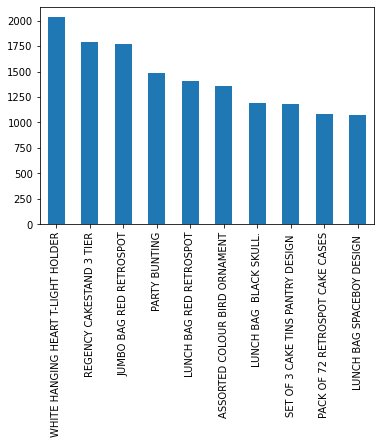

In [ ]:
pur_outlier_treat['Description'].value_counts().head(10).plot(kind = 'bar')

In [ ]:
pur_outlier_treat['Description'].value_counts(1).head(10)

WHITE HANGING HEART T-LIGHT HOLDER    0.004965
REGENCY CAKESTAND 3 TIER              0.004382
JUMBO BAG RED RETROSPOT               0.004323
PARTY BUNTING                         0.003637
LUNCH BAG RED RETROSPOT               0.003437
ASSORTED COLOUR BIRD ORNAMENT         0.003310
LUNCH BAG  BLACK SKULL.               0.002900
SET OF 3 CAKE TINS PANTRY DESIGN      0.002893
PACK OF 72 RETROSPOT CAKE CASES       0.002641
LUNCH BAG SPACEBOY DESIGN             0.002609
Name: Description, dtype: float64

In [ ]:
pur_outlier_treat['Description'].value_counts(0).head(10)

WHITE HANGING HEART T-LIGHT HOLDER    2034
REGENCY CAKESTAND 3 TIER              1795
JUMBO BAG RED RETROSPOT               1771
PARTY BUNTING                         1490
LUNCH BAG RED RETROSPOT               1408
ASSORTED COLOUR BIRD ORNAMENT         1356
LUNCH BAG  BLACK SKULL.               1188
SET OF 3 CAKE TINS PANTRY DESIGN      1185
PACK OF 72 RETROSPOT CAKE CASES       1082
LUNCH BAG SPACEBOY DESIGN             1069
Name: Description, dtype: int64

# 모델링
### 연관성 모델 생성
- 장바구니 분석(컨텐츠 기반 추천(contents-based recommendation))
-  apriori, fpgrowth  


In [ ]:
df['WHITE HANGING HEART T-LIGHT HOLDER'].mean()

0.11111735927571276

In [ ]:
freq_itemsets1 = fpgrowth(df, min_support = 0.01, max_len = 3, use_colnames = True)
## 지지도 설정은 룰 확인해보면서, 탐색적으로 설정! 보통 0.01~0.05

In [ ]:
freq_itemsets1

,support,itemsets
0,0.111117,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.021762,(KNITTED UNION FLAG HOT WATER BOTTLE)
2,0.020975,(RED WOOLLY HOTTIE WHITE HEART.)
3,0.017320,(SET 7 BABUSHKA NESTING BOXES)
4,0.014058,(WHITE METAL LANTERN)
...,...,...
1196,0.010178,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG VINTAGE..."
1197,0.010178,"(LUNCH BAG VINTAGE DOILY , LUNCH BAG APPLE DES..."
1198,0.012146,"(HOT WATER BOTTLE KEEP CALM, LOVE HOT WATER BO..."
1199,0.014058,"(HOT WATER BOTTLE KEEP CALM, CHOCOLATE HOT WAT..."


In [ ]:
rules_conf_20 = association_rules(freq_itemsets1, metric = 'confidence', min_threshold= 0.5)
# confidence 해석 : 1이라면, A를 산사람이면 무조건 B도 같이 산다는 의미

In [ ]:
rules_conf_20.sort_values(by='lift', ascending = False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
434,(REGENCY TEA PLATE PINK),"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...",0.012540,0.012540,0.010291,0.820628,65.440467,0.010133,5.505089
433,"(REGENCY TEA PLATE GREEN , REGENCY TEA PLATE R...",(REGENCY TEA PLATE PINK),0.012540,0.012540,0.010291,0.820628,65.440467,0.010133,5.505089
432,"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROS...",(REGENCY TEA PLATE GREEN ),0.010966,0.015014,0.010291,0.938462,62.504350,0.010126,16.006017
435,(REGENCY TEA PLATE GREEN ),"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE ROS...",0.015014,0.010966,0.010291,0.685393,62.504350,0.010126,3.143717
427,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012540,0.015014,0.011247,0.896861,59.733629,0.011058,9.550078
428,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.015014,0.012540,0.011247,0.749064,59.733629,0.011058,3.935102
436,(REGENCY TEA PLATE ROSES ),"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE GRE...",0.018051,0.011247,0.010291,0.570093,50.689860,0.010088,2.299926
431,"(REGENCY TEA PLATE PINK, REGENCY TEA PLATE GRE...",(REGENCY TEA PLATE ROSES ),0.011247,0.018051,0.010291,0.915000,50.689860,0.010088,11.552342
423,(REGENCY SUGAR BOWL GREEN),(REGENCY MILK JUG PINK ),0.014958,0.015296,0.011584,0.774436,50.631607,0.011355,4.365523
424,(REGENCY MILK JUG PINK ),(REGENCY SUGAR BOWL GREEN),0.015296,0.014958,0.011584,0.757353,50.631607,0.011355,4.059567


In [ ]:
freq_itemsets2 = fpgrowth(df, min_support = 0.01, max_len = 2, use_colnames = True)

In [ ]:
rules_conf_2 = association_rules(freq_itemsets2, metric = 'confidence', min_threshold= 0.5)

In [ ]:
rules_conf_2.sort_values(by='lift', ascending = False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
162,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.015014,0.012540,0.011247,0.749064,59.733629,0.011058,3.935102
161,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012540,0.015014,0.011247,0.896861,59.733629,0.011058,9.550078
157,(REGENCY SUGAR BOWL GREEN),(REGENCY MILK JUG PINK ),0.014958,0.015296,0.011584,0.774436,50.631607,0.011355,4.365523
158,(REGENCY MILK JUG PINK ),(REGENCY SUGAR BOWL GREEN),0.015296,0.014958,0.011584,0.757353,50.631607,0.011355,4.059567
164,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.018051,0.012540,0.010966,0.607477,48.442857,0.010739,2.515672
163,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES ),0.012540,0.018051,0.010966,0.874439,48.442857,0.010739,7.820523
156,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE GREEN ),0.018051,0.015014,0.012540,0.694704,46.269371,0.012269,3.226331
155,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE ROSES ),0.015014,0.018051,0.012540,0.835206,46.269371,0.012269,5.958645
109,(PINK POLKADOT CUP),(BLUE POLKADOT CUP),0.014902,0.016027,0.010572,0.709434,44.266190,0.010333,3.386402
110,(BLUE POLKADOT CUP),(PINK POLKADOT CUP),0.016027,0.014902,0.010572,0.659649,44.266190,0.010333,2.894360
